**REMEMBER**: add the config file `~/.pylidcrc` in the root directory that specifies where the dataset is store on your machine
```
[dicom]
path = .../path/LIDC-IDRI
warn = True
```

In [1]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt

# to avoid error in pylidc due to deprecated types:
np.int = int
np.float = float

# `Scan` class
[see class docs here](https://pylidc.github.io/scan.html)
- The `pylidc.Scan` class holds some (but not all!) of the DICOM attributes associated with the CT scans in the LIDC dataset. These attributes can be used to query the data.
- A `pylidc.Scan` object has zero or more pylidc.Annotation objects, which are radiologist annotations of lung nodules found in the scan:

In [12]:
# get the first scan
scan = pl.query(pl.Scan).first()
print(scan.study_instance_uid)
print(scan.series_instance_uid)
print(scan.patient_id)
print(scan.slice_thickness)
print(scan.zvals)

1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432
1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824
LIDC-IDRI-0078
3.0
[Zval(id=1,scan_id=1,val=1403.500000), Zval(id=2,scan_id=1,val=1406.500000), Zval(id=3,scan_id=1,val=1409.500000), Zval(id=4,scan_id=1,val=1412.500000), Zval(id=5,scan_id=1,val=1415.500000), Zval(id=6,scan_id=1,val=1418.500000), Zval(id=7,scan_id=1,val=1421.500000), Zval(id=8,scan_id=1,val=1424.500000), Zval(id=9,scan_id=1,val=1427.500000), Zval(id=10,scan_id=1,val=1430.500000), Zval(id=11,scan_id=1,val=1433.500000), Zval(id=12,scan_id=1,val=1436.500000), Zval(id=13,scan_id=1,val=1439.500000), Zval(id=14,scan_id=1,val=1442.500000), Zval(id=15,scan_id=1,val=1445.500000), Zval(id=16,scan_id=1,val=1448.500000), Zval(id=17,scan_id=1,val=1451.500000), Zval(id=18,scan_id=1,val=1454.500000), Zval(id=19,scan_id=1,val=1457.500000), Zval(id=20,scan_id=1,val=1460.500000), Zval(id=21,scan_id=1,val=1463.500000), Zval(id=22,scan_id=1,val=1466.500000), Z

In [8]:
# how to filter/query scans
scans = pl.query(pl.Scan).filter(pl.Scan.slice_thickness <= 1,
                                 pl.Scan.pixel_spacing <= 0.6).all()
len(scans)

31

In [10]:
# Descriptics
total_scan_counts = pl.query(pl.Scan).count()
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).count()
print("Total number of scans: ", total_scan_counts)
print("Number of scans with annotations: ", scans_with_annotations)

Total number of scans:  1018
Number of scans with annotations:  883


In [5]:
# to open the plot interactively:
%matplotlib qt

# utils
scan = pl.query(pl.Scan).first() # get a scan

# images = scan.load_all_dicom_images(verbose=False) # load all DICOM images for this scan
# print(len(images))

# scan_dir = scan.get_path_to_dicom_files() # get the path to the DICOM files for this scan

# return the scan as a 3D numpy array
# volumne = scan.to_volume(verbose=False)

# cluster the annotations
nodules = scan.cluster_annotations()

# visualise the scan

scan.visualize(annotation_groups=nodules)

%matplotlib inline

Loading dicom files ... This may take a moment.


: 

# `Annotation` class
[see class docs here](https://pylidc.github.io/annotation.html)

The Nodule model class holds the information from a single physicians annotation of a nodule >= 3mm class with a particular scan. A nodule has many contours, each of which refers to the contour drawn for nodule in each scan slice.

Refer to the documentation link above for semantic describtions of what the different values mean.

In [37]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.spiculation > 3).first()

'Non-central'

In [35]:
# Descriptics
annotations_count = pl.query(pl.Annotation).count()
print("Total number of annotations: ", annotations_count)

print("----------------------------------------")

print("Number of annotations by malignancy:")
for i in range(5):
    ann = pl.query(pl.Annotation).filter(pl.Annotation.malignancy == i)
    print(f"Malignancy {i +1}: {ann.count()}")

print("----------------------------------------")

print("Number of annotations by subtlety:")
for i in range(5):
    ann = pl.query(pl.Annotation).filter(pl.Annotation.subtlety == i)
    print(f"Subtlety {i +1}: {ann.count()}")

# etc ...

Total number of annotations:  6859
----------------------------------------
Number of annotations by malignancy:
Malignancy 1: 0
Malignancy 2: 1020
Malignancy 3: 1580
Malignancy 4: 2606
Malignancy 5: 962
----------------------------------------
Number of annotations by subtlety:
Subtlety 1: 0
Subtlety 2: 349
Subtlety 3: 625
Subtlety 4: 1446
Subtlety 5: 1897
----------------------------------------


# Utils - Annotation consensus and Volume Viewer
The `pylidc.utils.consensus()` utility accepts a list of annotations to produce a single boolean-valued volume of those annotations. It also returns the individual boolean masks for each Annotation, placed in a common frame of reference – i.e., a common bounding box, which is also returned.

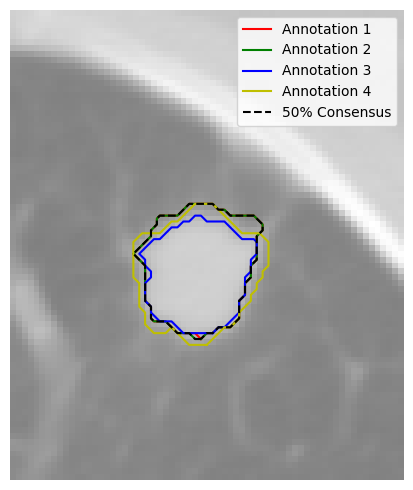

In [17]:
# see https://pylidc.github.io/utils.html#pylidc.utils.consensus for utils documentation
from pylidc.utils import consensus
from skimage.measure import find_contours

def show_segmentation_consensus(scan: pl.Scan, nodule_idx: int, clevel: float = 0.5) -> None:
    """
    Display the consensus segmentation for a nodule in a scan.

    Args:
        @scan: The pylidc.Scan object.
        @nodule_idx: The index of the nodule in the scan.
        @clevel: The consensus fraction. For example, if clevel=0.5, then a voxel will have value 1 (True) in the returned boolean volume when at least 50% of the annotations have a value of 1 at that voxel, and 0 (False) otherwise.
        @pad: The number of slices to pad the volume by in the z-direction.
    """
    # Query for a scan, and convert it to an array volume.
    vol = scan.to_volume(verbose=False)

    # Cluster the annotations for the scan, and grab one.
    nods = scan.cluster_annotations()
    anns = nods[nodule_idx] # TODO maybe this should be the nodule id ??

    # Perform a consensus consolidation and 50% agreement level.
    # We pad the slices to add context for viewing.
    cmask, cbbox, masks = consensus(anns, clevel=clevel, pad=[(20,20), (20,20), (0,0)])

    # Get the central slice of the computed bounding box.
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))

    # Set up the plot.
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

    ax.axis('off')
    ax.legend()
    plt.tight_layout()
    plt.show()

show_segmentation_consensus(scan, nodule_idx=1)

In [53]:
from pylidc.utils import volume_viewer

# to open the plot interactively:
%matplotlib qt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume(verbose=False)
np.float = float
padding = 120.0

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

volume_viewer(vol[bbox], mask, ls='-', lw=2, c='r')

# to close the plot again:
%matplotlib inline

UsageError: unrecognized arguments: # to close the plot


# Util funcs

In [25]:
# all util functions
def get_scans_by_patient_id(patient_id: str) -> list[pl.Scan]:
    """Returns all scans for a given patient_id"""
    scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
    return scans


def get_annotations_by_scan_id(scan_id: int) -> list[pl.Annotation]:
    """Returns all annotations for a given scan_id"""
    annotations = pl.query(pl.Annotation).filter(pl.Annotation.scan_id == scan_id).all()
    return annotations


def get_annotations_by_scan(scan: pl.Scan) -> list[pl.Annotation]:
    """Returns all annotations for a given scan object"""
    return scan.annotations

def get_nodules_by_scan(scan: pl.Scan) -> list[pl.Annotation]:
    """Returns all nodules for a given scan object"""
    return scan.cluster_annotations()


pid_scans = get_scans_by_patient_id("LIDC-IDRI-0010")
scan_annotations = get_annotations_by_scan_id(pid_scans[0].id)
scan_nodules = get_nodules_by_scan(pid_scans[0])

# get the malignancy of each annotation:
[s.malignancy for s in scan_annotations]

[4, 3, 4, 2, 2, 2, 2]